In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Choose which fields to use.
# CAFS, T, P, CloudFlag, cloudindicator, Solar_Zenith_Angle, Relative_Humidity
def get_col_names(file_path):
  fields = ['UTC_Start', 'G_LAT', 'G_LONG', 'G_ALT', 'T', 'Pres', 'CloudFlag_AMS', 'cloudindicator_CAPS', 'Solar_Zenith_Angle', 'Relative_Humidity']
  names = pd.read_csv(file_path, skiprows=13, nrows=340).to_numpy()[:,0]
  col_names = fields
  for item in names:
    if 'CAFS' in item:
      col_names.append(item)
  return col_names

# Get the relevant data.
def get_data(file_path, col_names):
  pre_rows = int((pd.read_csv(file_path, nrows=1, header=None))[0])
  relevant_data = pd.read_csv(file_path, skiprows=pre_rows-1, index_col=0, parse_dates=[0], usecols=col_names, na_values='-99999.0')
  return relevant_data

# Get the date and times.
def get_date_time(file_path, data):
  date = file_path[-16:-8]
  date = f'{date[0:4]}-{date[4:6]}-{date[6:8]}'
  data['UTC_Start_dt'] = pd.to_datetime(data.index, unit='s', origin=date)
  data.index = data['UTC_Start_dt']
  return data

In [ ]:
# Tests on 1 file.
file_path = '/content/drive/MyDrive/Photolysis data/ATom_MER10_Dataset.20210613/MER10_DC8_20160729_R35.ict'
'''
col_names = get_col_names(file_path)
print(len(col_names))
print(col_names)

data = get_data(file_path, col_names)
print(data.shape)
print(data[0:2])

data = get_date_time(file_path, data)
print(data[0:2])
'''

'\ncol_names = get_col_names(file_path)\nprint(len(col_names))\nprint(col_names)\n\ndata = get_data(file_path, col_names)\nprint(data.shape)\nprint(data[0:2])\n\ndata = get_date_time(file_path, data)\nprint(data[0:2])\n'

In [ ]:
# Compile all the photolysis data.
folder_path = '/content/drive/MyDrive/Photolysis data/ATom_MER10_Dataset.20210613'
all_files = glob.glob(folder_path + '/*.ict')
col_names = get_col_names(all_files[0])
all_data = []
# A few of the files have no photolysis data and will be ignored by the try-except.
for each_file in all_files:
  try:
    data = get_data(each_file, col_names)
    data = get_date_time(each_file, data)
    all_data.append(data)
  except:
    #print('A file did not contain all the fields')
    continue
all_data = pd.concat(all_data, axis=0)
all_data = all_data.drop(['UTC_Start_dt'], axis=1)

del col_names
del data


In [ ]:
# Make a .csv for easy viewing.
out_path = folder_path + '/photolysis_data.csv'
all_data.to_csv(out_path)

In [ ]:
def scatter(title, x, y, xlabel, ylabel, scale):
  plt.figure(figsize=(15, 5))
  plt.yscale(scale)
  plt.scatter(x, y)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

# Separate data for easier processing.
#space_data = all_data.iloc[:, 1:4]
J_data = all_data.iloc[:, 5:51]

# Show where there are no photolysis data.
title = 'Data distribution'
xlabel = 'Times of flights'
ylabel = 'Average photolysis rate recorded / per second'

x = all_data.index
y = J_data.mean(axis=1)
#scatter(title, x, y, xlabel, ylabel, 'log')

# Remove entries with no photolysis data but keep entries with some recorded and some missing.
no_empty_data = all_data.dropna(axis='rows', thresh=12)

num_empties = len(all_data.index) - len(no_empty_data.index)
print("There were {} entries with no photolysis.".format(num_empties))

all_data = no_empty_data
del no_empty_data

J_data = all_data.iloc[:, 5:51]

title = 'Without missing data'
x = all_data.index
y = J_data.mean(axis=1)
#scatter(title, x, y, xlabel, ylabel, 'log')

There were 1056 entries with no photolysis.


In [ ]:
# Remove empty entries from csv.
out_path = folder_path + '/photolysis_data.csv'
all_data.to_csv(out_path)

In [ ]:
# Check for outlying values.

# Check for negative values.
print((J_data < 0).sum().sum(), "negative values were found.\n")
#print("The smallest numbers are:\n", J_data.min(axis=0))
# Since the negative numbers are so close to zero, I assume they are actually zero.
J_data[J_data < 0] = 0.0
print((J_data < 0).sum().sum(), "negative values \n")
# Check for unreasonably large numbers.
#print("The largest numbers are:\n", J_data.max(axis=0))

title = "Without negative values"
x = J_data.index
y = J_data.mean(axis=1)
#scatter(title, x, y, xlabel, ylabel, 'log')

#print("The smallest numbers are:\n", J_data[J_data>0].min(axis=0))

# Check that all_data was updated.
all_data.iloc[:, 5:51] = J_data

In [72]:
# Check for outlying values.

# Check for negative values.
# No fields except lat and long should have any negative values.
all_pos = all_data.iloc[:, 3:]
print((all_pos < 0).sum().sum(), "negative values were found.\n")
print("The smallest numbers are:\n", all_data.min(axis=0))
# Since the negative numbers are so close to zero for J-rates, I assume they are actually zero.
J_data[J_data < 0] = 0.0
# Other fields with negative values should have those values removed.
all_pos[all_pos < 0] = None
print((all_pos < 0).sum().sum(), "negative values \n")
# Check for unreasonably large numbers.
print("The largest numbers are:\n", all_data.max(axis=0))

title = "Without negative values"
x = J_data.index
y = J_data.mean(axis=1)
#scatter(title, x, y, xlabel, ylabel, 'log')

# Check that all_data was updated.
all_data.iloc[:, 3:] = all_pos
del all_pos

0 negative values were found.

The smallest numbers are:
 T                                          196.594000
G_LAT                                      -86.176772
G_LONG                                    -179.999579
G_ALT                                       37.500000
CloudFlag_AMS                                0.000000
jO3_O2_O1D_CAFS                              0.000000
jNO2_NO_O3P_CAFS                             0.000000
jH2O2_OH_OH_CAFS                             0.000000
jNO3_NO_O2_CAFS                              0.000000
jNO3_NO2_O3P_CAFS                            0.000000
jN2O5_NO3_NO2_CAFS                           0.000000
jHNO2_OH_NO_CAFS                             0.000000
jHNO3_OH_NO2_CAFS                            0.000000
jHNO4_HO2_NO2_UvVisOnly_CAFS                 0.000000
jCH2O_H_HCO_CAFS                             0.000000
jCH2O_H2_CO_CAFS                             0.000000
jCH3CHO_CH3_HCO_CAFS                         0.000000
jPropanal_CH2CH3_HCO_CAF

<ipython-input-72-f203c2297c27>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  J_data[J_data < 0] = 0.0
<ipython-input-72-f203c2297c27>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  J_data[J_data < 0] = 0.0
<ipython-input-72-f203c2297c27>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_pos[all_pos < 0] = None
<ip

In [73]:
# Remove negative values from csv.
out_path = folder_path + '/photolysis_data.csv'
all_data.to_csv(out_path)

In [ ]:
# Look at rates during the progression of 1 flight of data.
file_path = '/content/drive/MyDrive/Documents/AI4ER/PhD/Photolysis_data/ATom_MER10_Dataset.20210613/MER10_DC8_20170129_R25.ict'
col_names = get_col_names(file_path)
data = get_data(file_path, col_names)
date, data = get_date_time(file_path, data)
data = data.drop(['UTC_Start_dt'], axis=1)
data = data.dropna(axis='rows', thresh=4)
space_data = data.iloc[0, 0:3]
j_data = data.iloc[:, 4:-1]
j_data[j_data < 0] = 0.0

print(j_data.index)

title = "Average photolysis measured during a flight in Jan 2017"
x = j_data.index
y = j_data.mean(axis=1)
xlabel = "UTC / month, day, hour"
scatter(title, x, y, xlabel, ylabel, 'linear')

FileNotFoundError: ignored

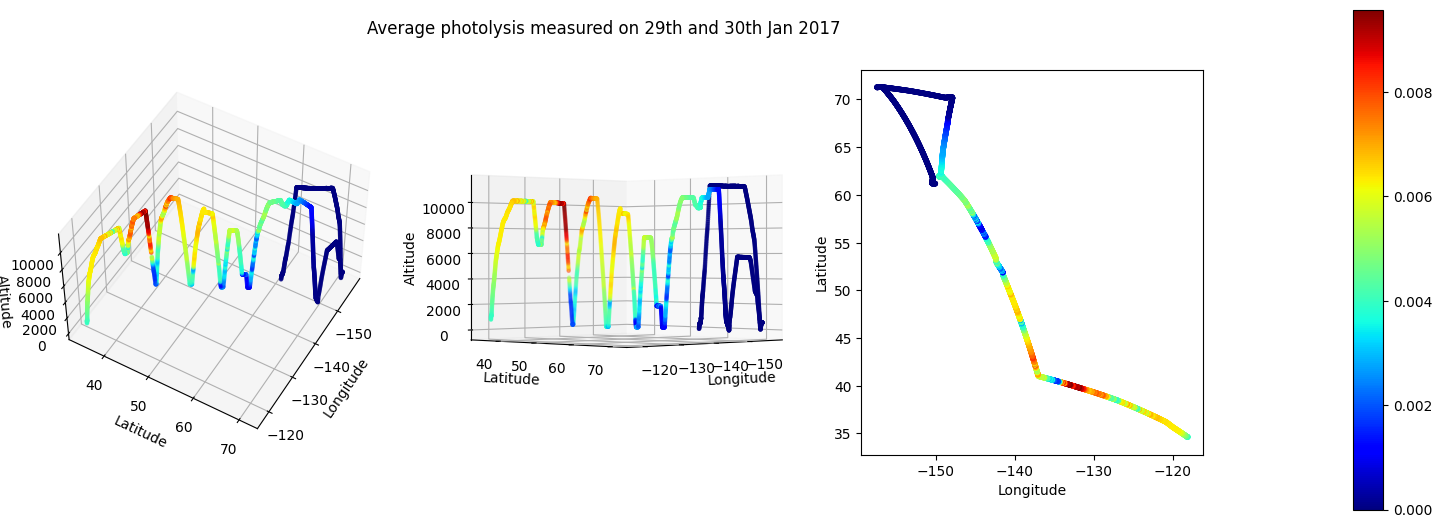

In [ ]:
# Plot an example of photolysis rates in space during 1 flight.
x = data['G_LONG']
y = data['G_LAT']
z = data['G_ALT']
j_avg = j_data.mean(axis=1)

fig = plt.figure(figsize=(15,5))

views=[(50,30), (0,45)]

fig.suptitle("Average photolysis measured on 29th and 30th Jan 2017")

for i in range(3):
  if i == 2:
    ax = fig.add_subplot(1, 3, i+1)
    pic = ax.scatter(x, y, c=j_avg, cmap='jet', marker='.')
  else:
    ax = fig.add_subplot(1, 3, i+1, projection="3d")
    ax.view_init(views[i][0], views[i][1])
    pic = ax.scatter(x, y, z, c=j_avg, cmap='jet', marker='.')
    ax.set_zlabel("Altitude")
  ax.set_xlabel("Longitude")
  ax.set_ylabel("Latitude")

plt.colorbar(pic, cax=fig.add_axes([1, 0, 0.02, 1]))
plt.show()

In [ ]:
del all_data
del no_empty_data
del j_data